# Import Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, KFold
from math import sqrt

plt.style.use('seaborn-darkgrid')

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [3]:
UneploymentDF = pd.read_csv('COVIDUnemployment.csv')
UneploymentDF.head()

,State,cases,deaths,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018
0,Alabama,387786,14345,2216627,2130845,85782,3.9,49881
1,Alaska,18316,367,352662,329901,22761,6.5,74912
2,Arizona,426614,18857,3422583,3260518,162065,4.7,59079
3,Arkansas,161569,3301,1353305,1303995,49310,3.6,47094
4,California,2664110,102387,19280821,18460725,820096,4.3,75250


In [4]:
UneploymentDF = UneploymentDF.drop(columns = ['cases', 'deaths', 'Unemployment_rate_2018'])
UneploymentDF.head()

,State,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Median_Household_Income_2018
0,Alabama,2216627,2130845,85782,49881
1,Alaska,352662,329901,22761,74912
2,Arizona,3422583,3260518,162065,59079
3,Arkansas,1353305,1303995,49310,47094
4,California,19280821,18460725,820096,75250


In [5]:
COVID = pd.read_csv('COVID.csv', index_col = 0)
COVID.head()

,State,cases,deaths
0,Alabama,59067,1211
1,Alaska,1954,15
2,Arizona,131411,2442
3,Arkansas,30297,335
4,California,355497,7368


In [6]:
UneploymentDF = pd.merge(UneploymentDF, COVID, how = 'left', on = 'State')
UneploymentDF.head()

,State,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Median_Household_Income_2018,cases,deaths
0,Alabama,2216627,2130845,85782,49881,59067,1211
1,Alaska,352662,329901,22761,74912,1954,15
2,Arizona,3422583,3260518,162065,59079,131411,2442
3,Arkansas,1353305,1303995,49310,47094,30297,335
4,California,19280821,18460725,820096,75250,355497,7368


In [7]:
test_len = int(0.25 * len(UneploymentDF))
train_len = len(UneploymentDF) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = UneploymentDF[:train_len]
test = UneploymentDF[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 7)
Test Set Shape: (12, 7)


## Civilian Labor Force

In [8]:
features_list = ['Civilian_labor_force_2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

<ipython-input-8-44e86b79d118>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForestModel.fit(X_train_scaled, y_train_scaled)


Train MAE Value: 9132.49051282052
Train MSE Value: 217593399.86249492
Train RMS Value: 14751.047415776784
Train R2 Score: 0.9750648775992796


Test MAE Value: 17789.472500000025
Test MSE Value: 908264961.3025423
Test RMS Value: 30137.434550779904
Test R2 Score: 0.846589984412152


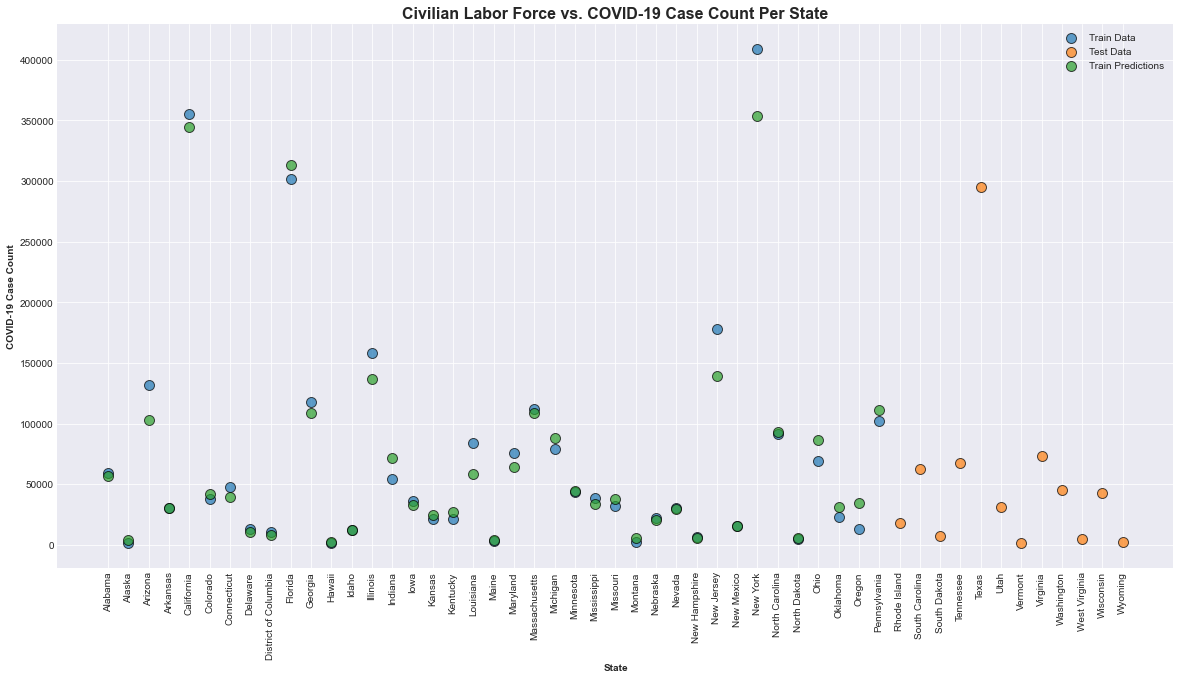

In [9]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Civilian Labor Force vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

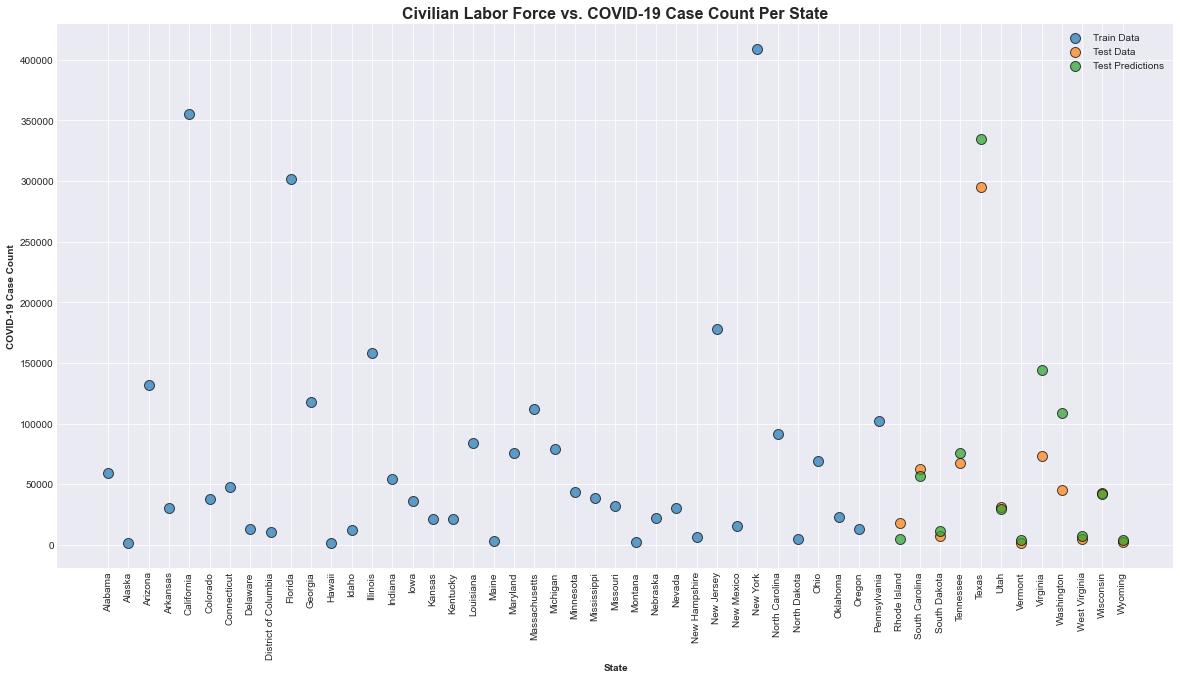

In [10]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Civilian Labor Force vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [11]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8803 degrees.
Accuracy = 78.98%.


78.98086126517521

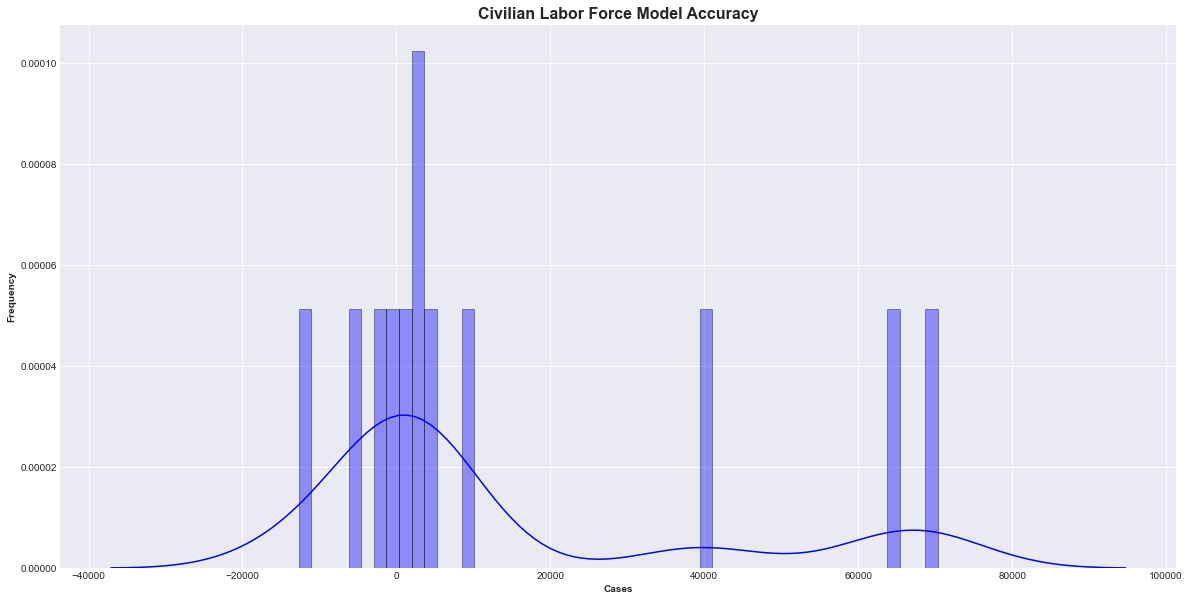

In [12]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Civilian Labor Force Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [13]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [8, 10, 12, 16, 20, 24],
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}

kfold = KFold(n_splits = 4)

RF_NewModel = GridSearchCV(estimator = RandomForestModel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

RF_NewModel.fit(X_train_scaled, y_train_scaled);

Fitting 4 folds for each of 1080 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 45.1min finished
c:\python38\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [14]:
RF_NewModel.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 100}

In [15]:
train_predictions_scaled = RF_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RF_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 16070.780933856751
Train MSE Value: 672099640.3309206
Train RMS Value: 25924.884577002857
Train R2 Score: 0.9229807208871125


Test MAE Value: 15879.6038235838
Test MSE Value: 627795150.769143
Test RMS Value: 25055.840651814957
Test R2 Score: 0.8939625902475072


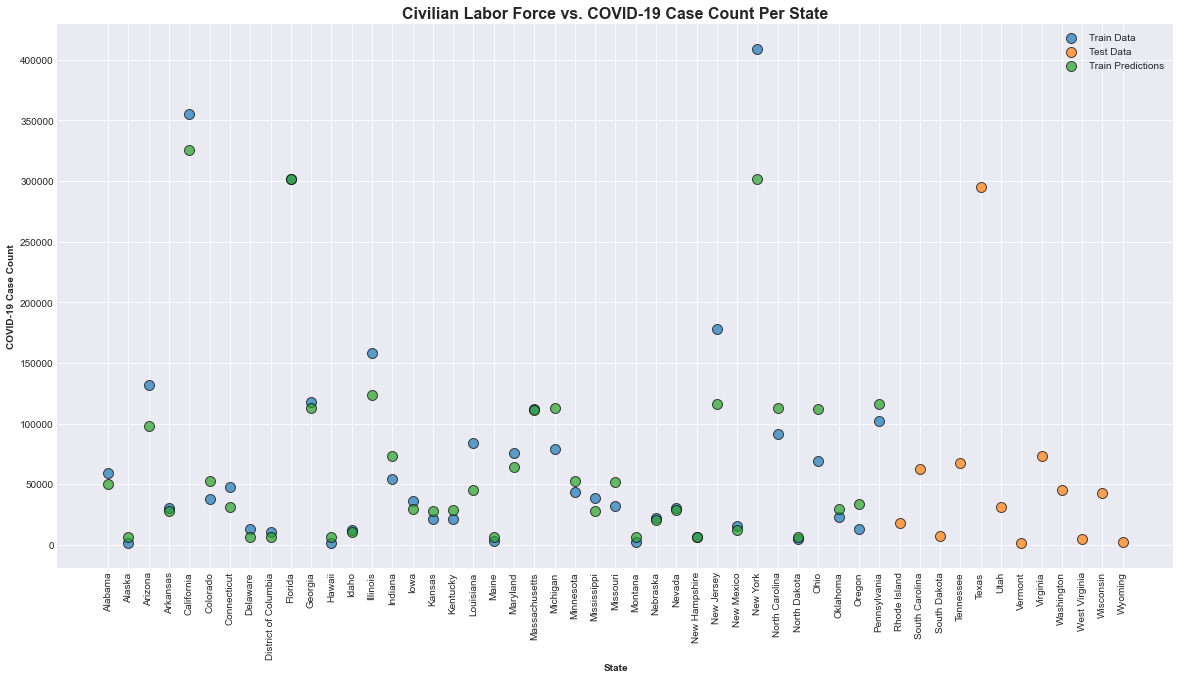

In [16]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Civilian Labor Force vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

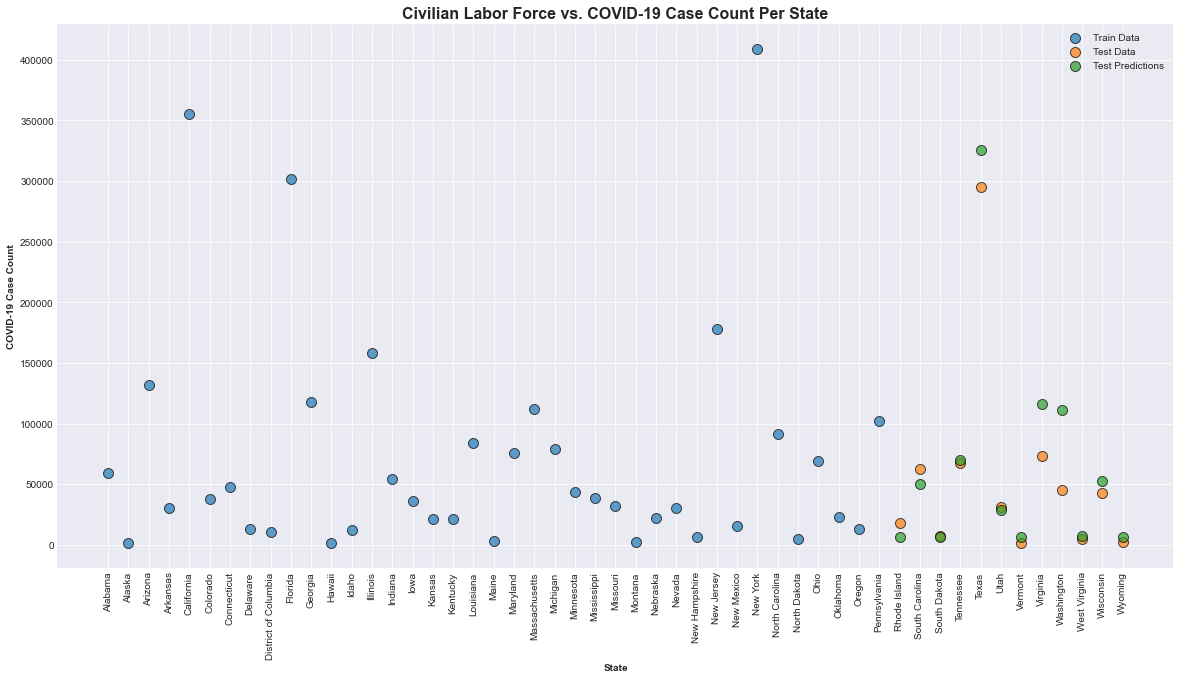

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Civilian Labor Force vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [18]:
base_accuracy = evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8803 degrees.
Accuracy = 78.98%.


In [19]:
new_accuracy = evaluate(RF_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8643 degrees.
Accuracy = 79.97%.


In [20]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 1.23%.


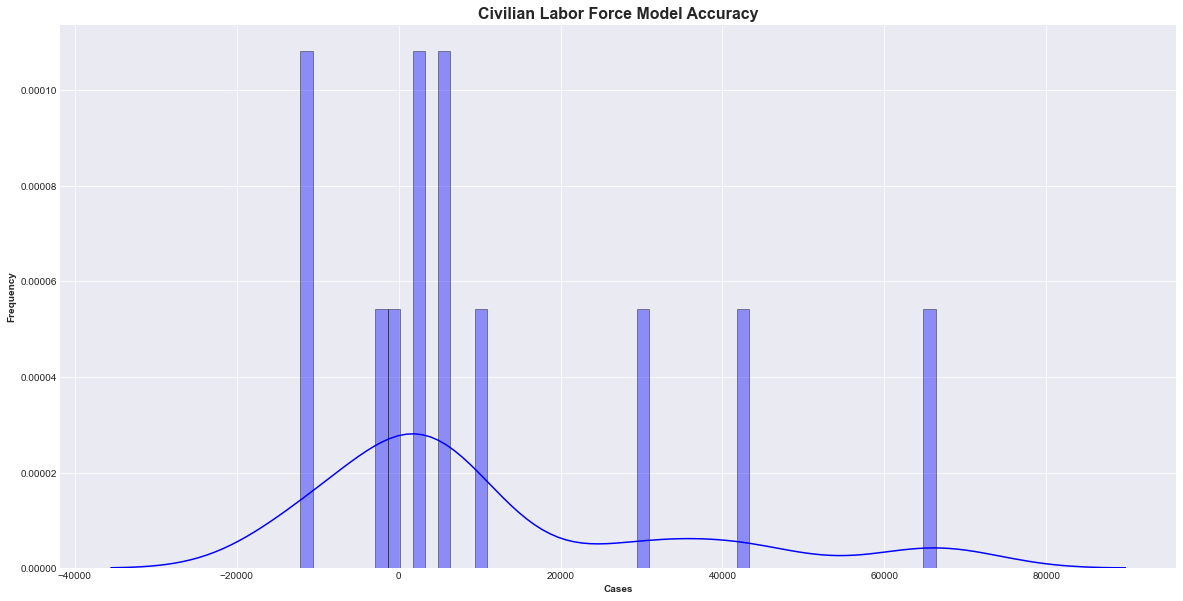

In [21]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Civilian Labor Force Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Employed

In [22]:
features_list = ['Employed_2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

<ipython-input-22-d1a521ef93a3>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForestModel.fit(X_train_scaled, y_train_scaled)


Train MAE Value: 9848.321538461543
Train MSE Value: 224259465.38320494
Train RMS Value: 14975.29516848349
Train R2 Score: 0.9743009796143446


Test MAE Value: 17063.172500000033
Test MSE Value: 733433152.8641602
Test RMS Value: 27081.970992971692
Test R2 Score: 0.8761198590638395


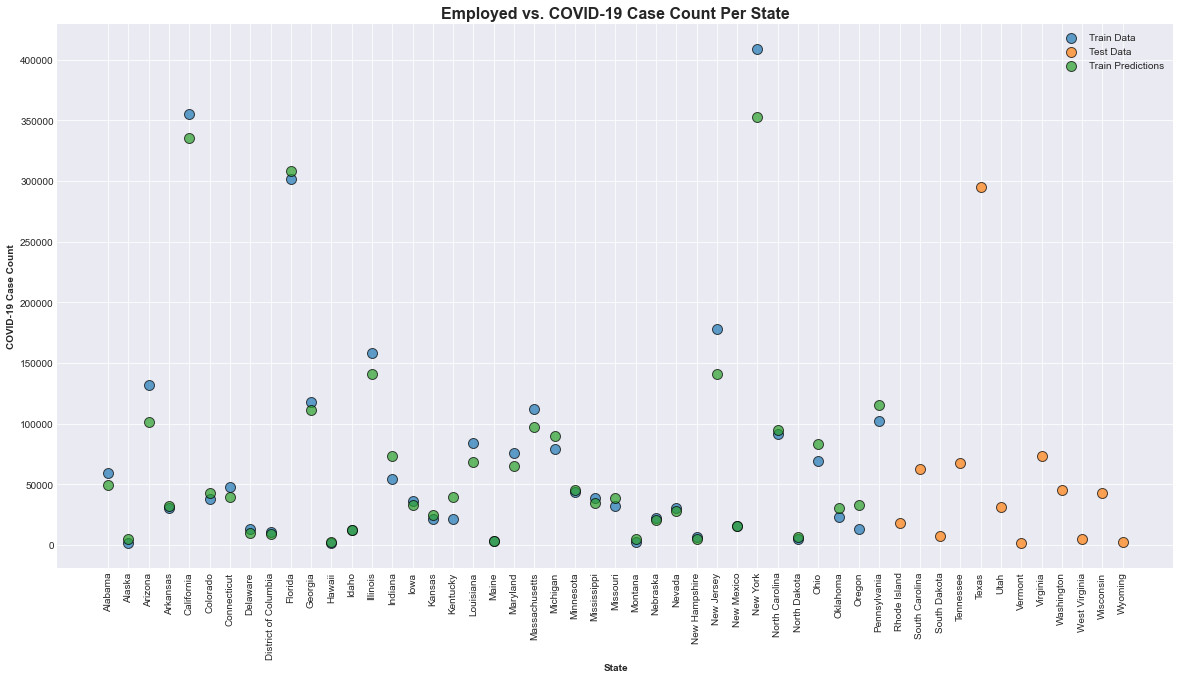

In [23]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Employed vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

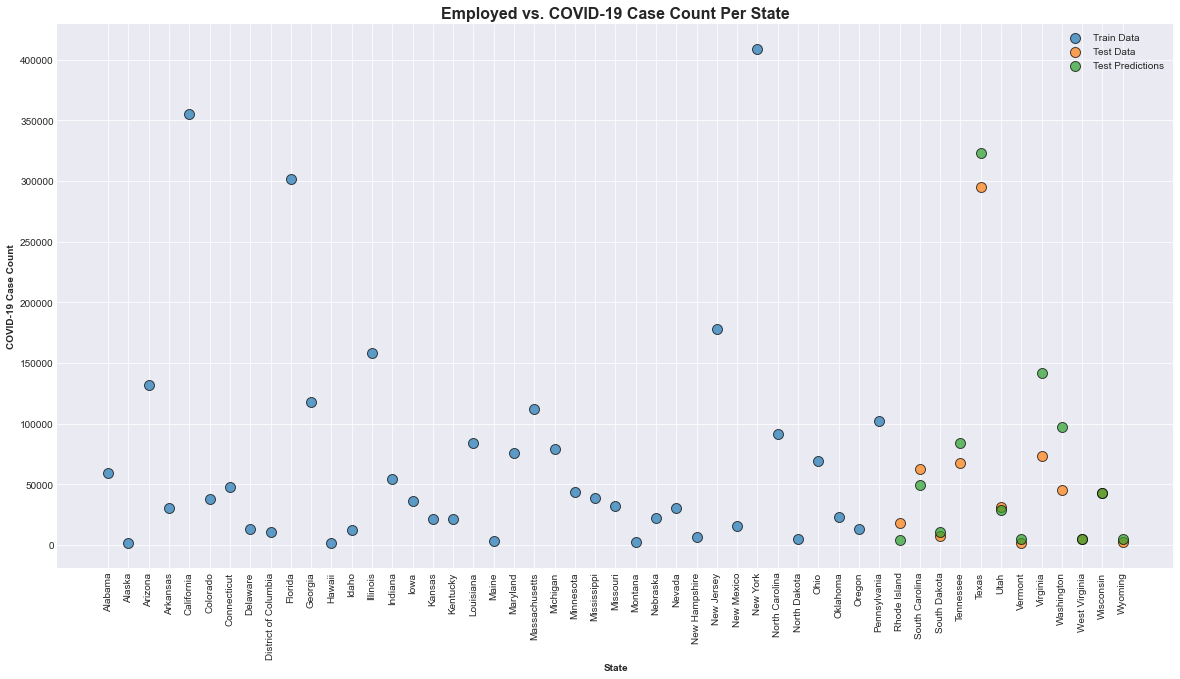

In [24]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Employed vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [25]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8771 degrees.
Accuracy = 79.98%.


79.98061407619974

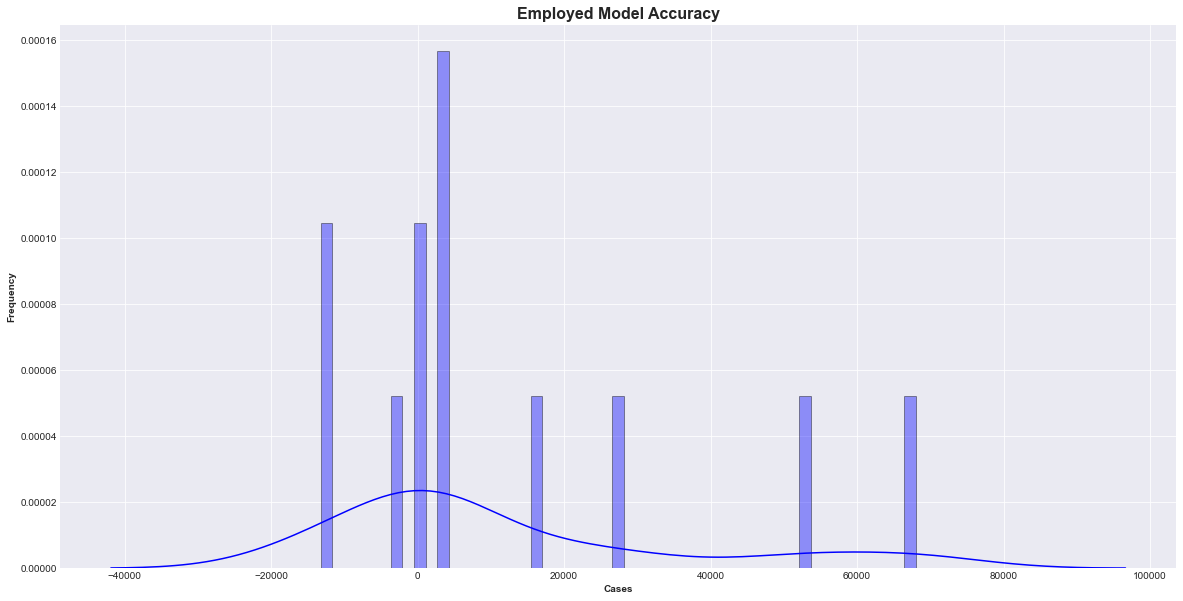

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Employed Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [27]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [8, 10, 12, 16, 20, 24],
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}

kfold = KFold(n_splits = 4)

RF_NewModel = GridSearchCV(estimator = RandomForestModel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

RF_NewModel.fit(X_train_scaled, y_train_scaled);

Fitting 4 folds for each of 1080 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 26.8min finished
c:\python38\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [28]:
RF_NewModel.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 300}

In [29]:
train_predictions_scaled = RF_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RF_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 17219.579196336523
Train MSE Value: 759592289.954103
Train RMS Value: 27560.70191330589
Train R2 Score: 0.9129544979920429


Test MAE Value: 15972.017029597531
Test MSE Value: 550853307.7235252
Test RMS Value: 23470.264330073598
Test R2 Score: 0.9069584117796496


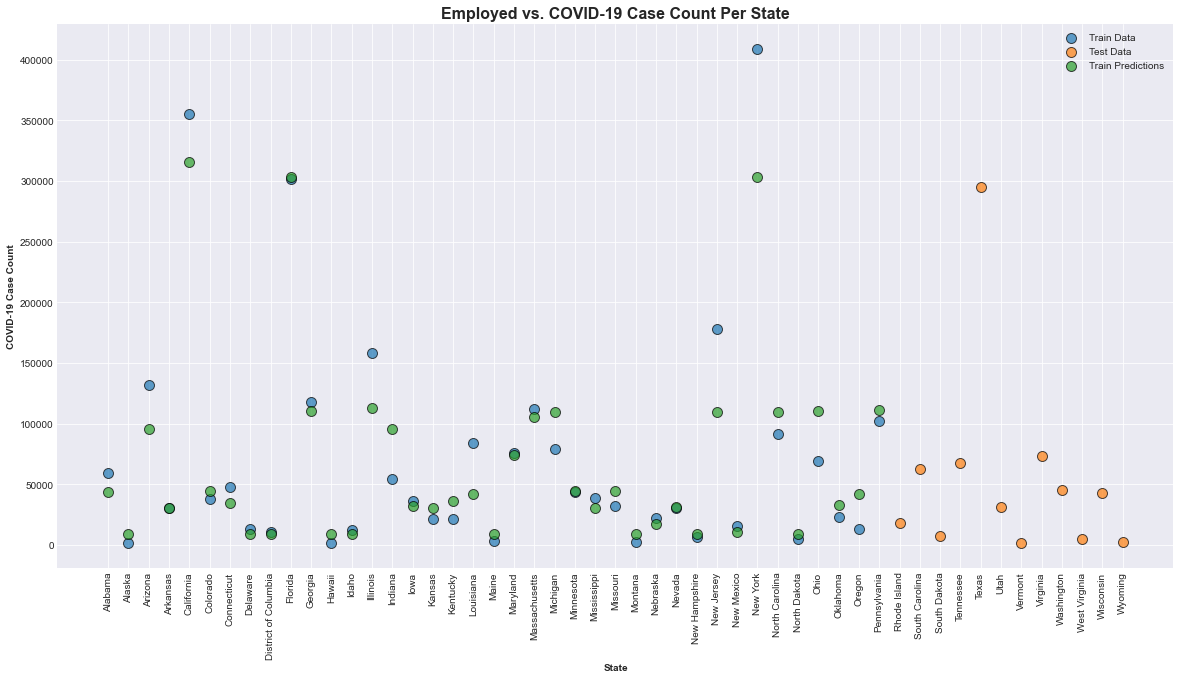

In [30]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Employed vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

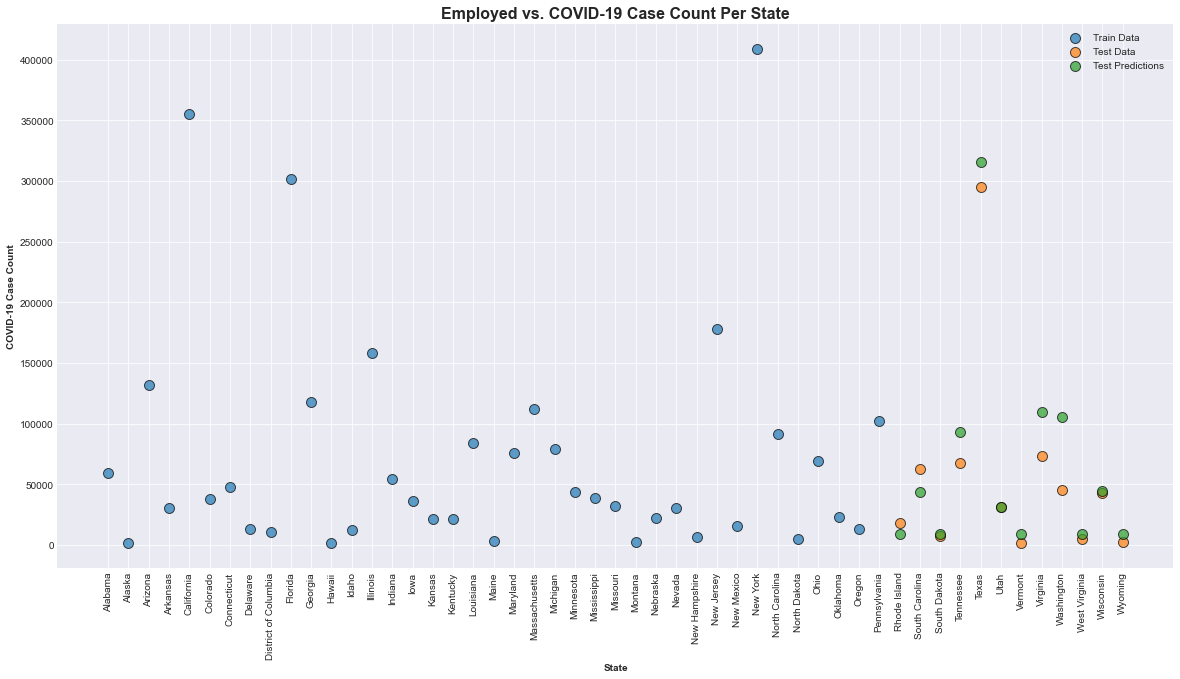

In [31]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Employed vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [32]:
base_accuracy = evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8771 degrees.
Accuracy = 79.98%.


In [33]:
new_accuracy = evaluate(RF_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8549 degrees.
Accuracy = 80.75%.


In [34]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 0.95%.


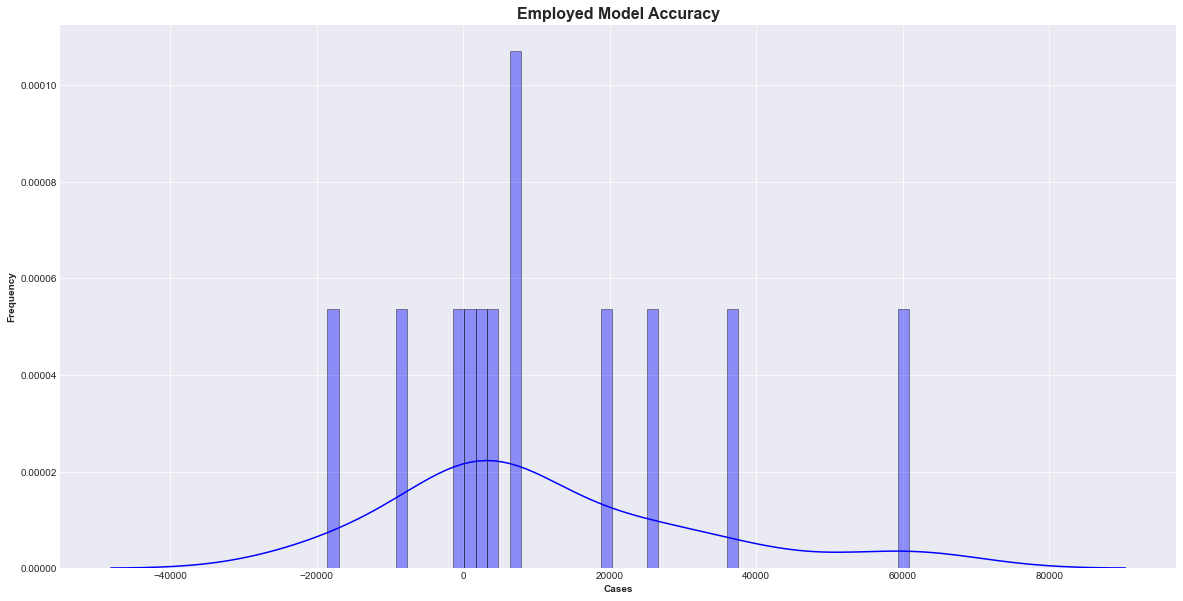

In [35]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Employed Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Unemployed

In [36]:
features_list = ['Unemployed_2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

<ipython-input-36-733f483efd3b>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForestModel.fit(X_train_scaled, y_train_scaled)


Train MAE Value: 8801.389487179491
Train MSE Value: 165906172.0512643
Train RMS Value: 12880.456981460879
Train R2 Score: 0.9809879770721561


Test MAE Value: 22524.053333333326
Test MSE Value: 1216915438.1554666
Test RMS Value: 34884.31507361821
Test R2 Score: 0.7944575379536878


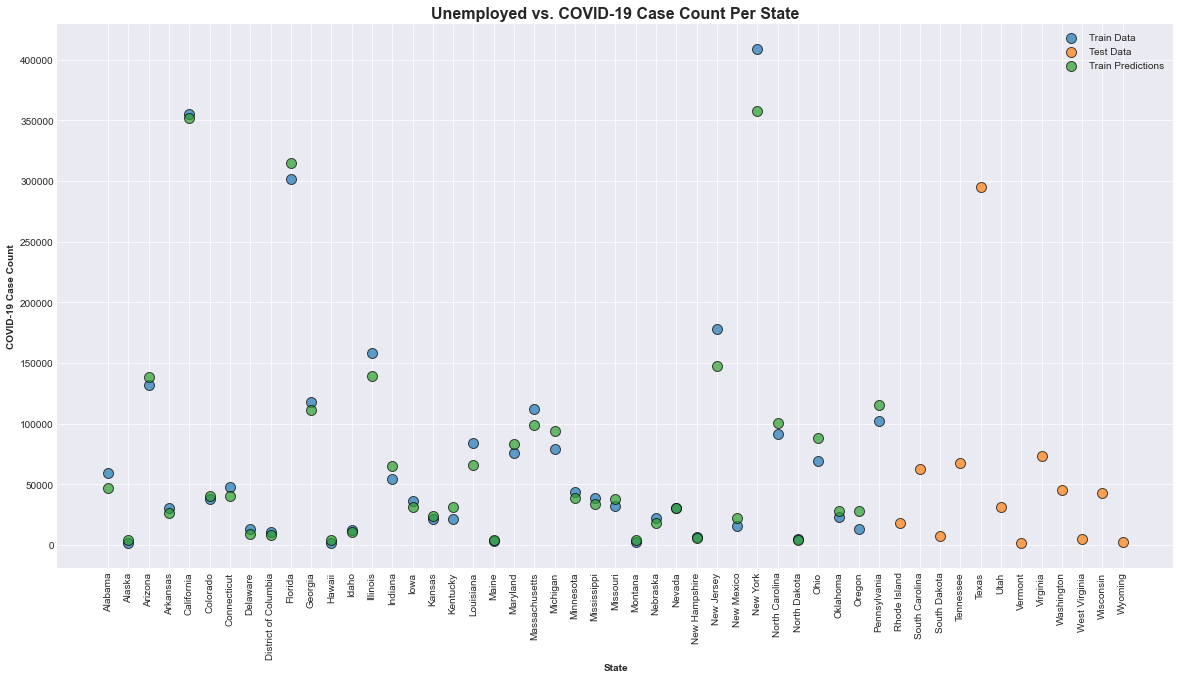

In [37]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Unemployed vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

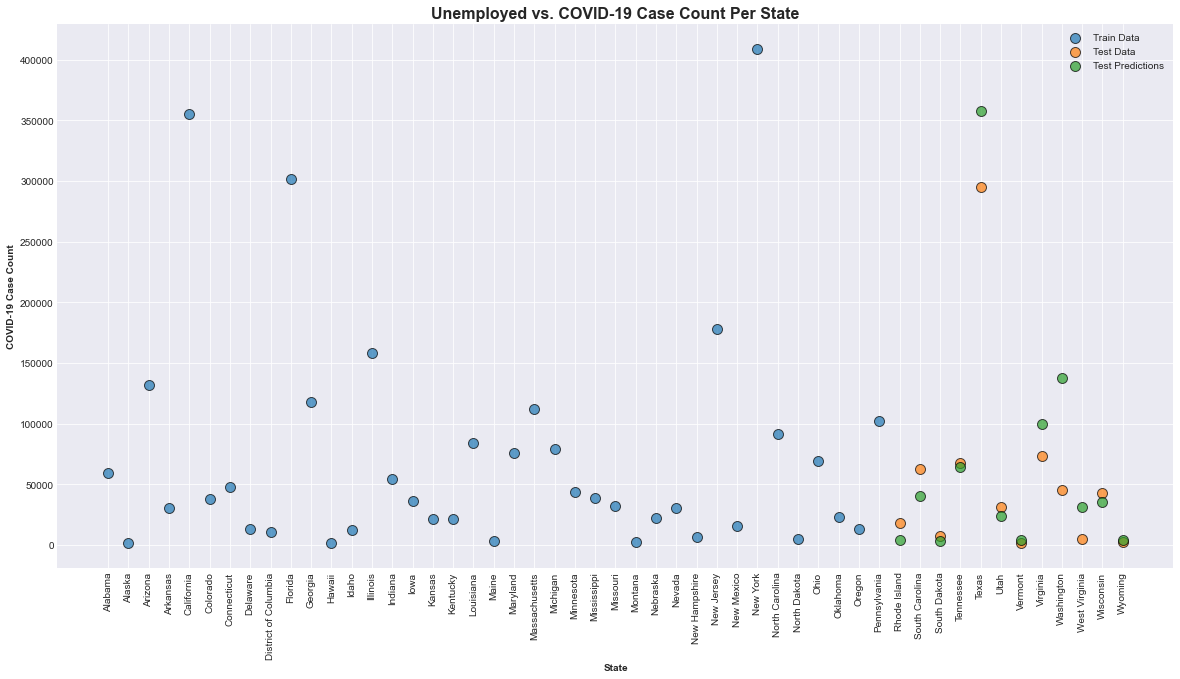

In [38]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Unemployed vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [39]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8963 degrees.
Accuracy = 79.84%.


79.84379211963109

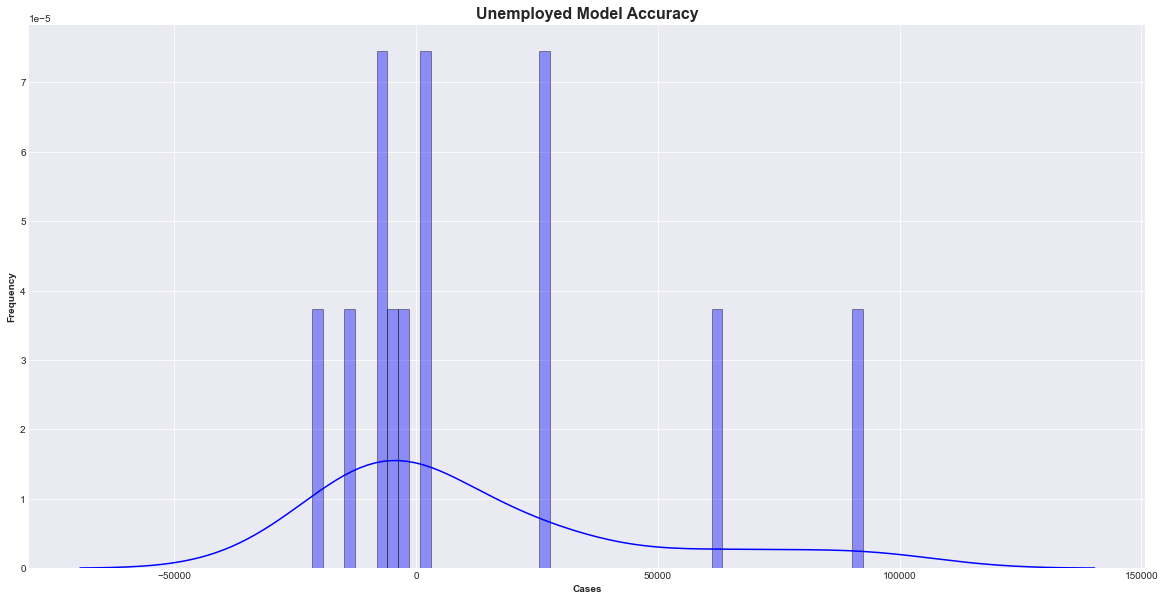

In [40]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Unemployed Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [41]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [8, 10, 12, 16, 20, 24],
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}

kfold = KFold(n_splits = 4)

RF_NewModel = GridSearchCV(estimator = RandomForestModel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

RF_NewModel.fit(X_train_scaled, y_train_scaled);

Fitting 4 folds for each of 1080 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 25.5min finished
c:\python38\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [42]:
RF_NewModel.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 100}

In [43]:
train_predictions_scaled = RF_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RF_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 16246.196187555104
Train MSE Value: 623681221.3177111
Train RMS Value: 24973.61049823816
Train R2 Score: 0.9285292311144755


Test MAE Value: 17289.365451158104
Test MSE Value: 598950406.1713928
Test RMS Value: 24473.463305617224
Test R2 Score: 0.8988345966629285


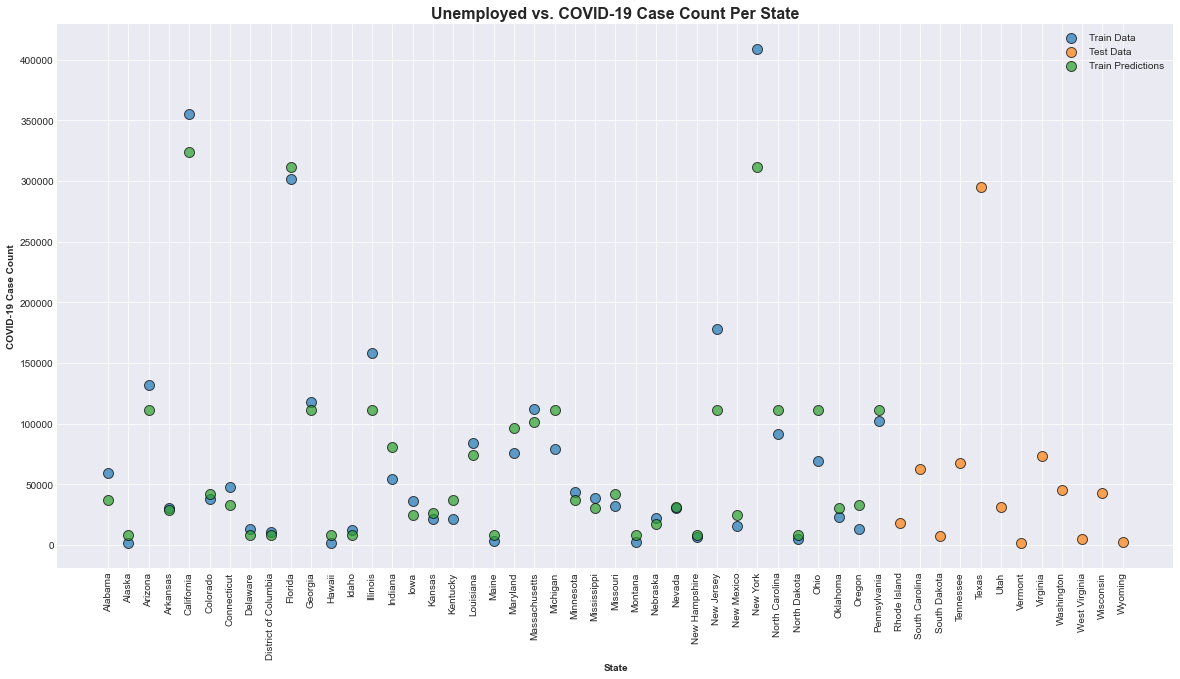

In [44]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Unemployed vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

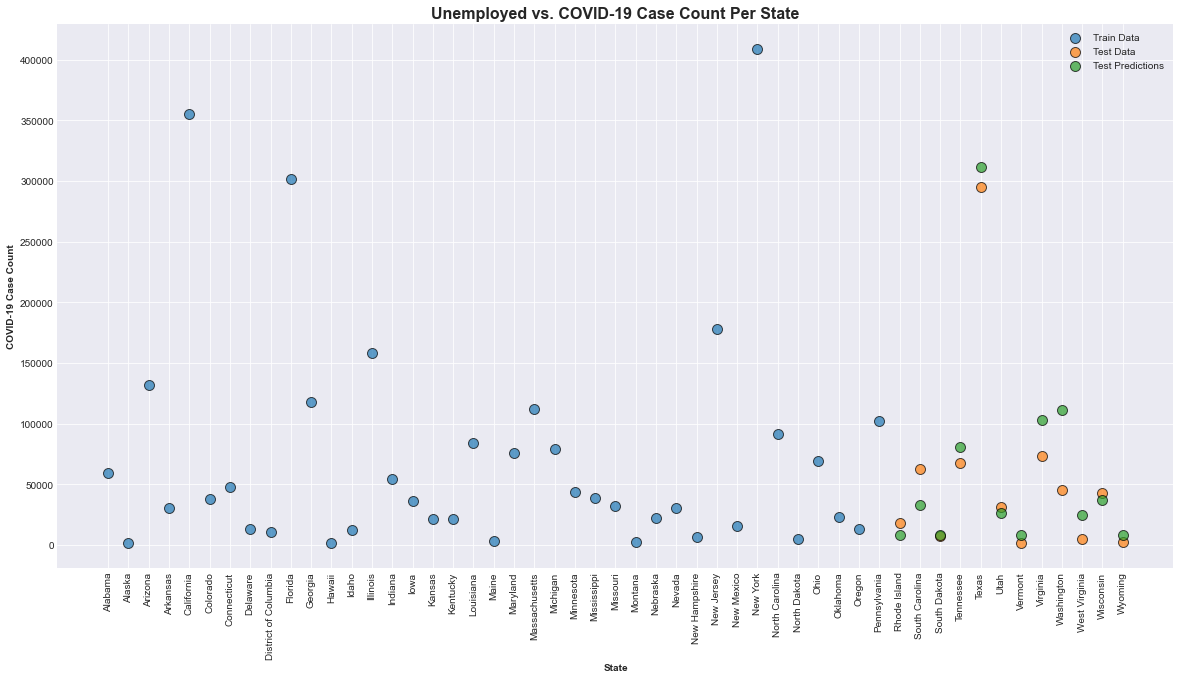

In [45]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Unemployed vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [46]:
base_accuracy = evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8963 degrees.
Accuracy = 79.84%.


In [47]:
new_accuracy = evaluate(RF_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8663 degrees.
Accuracy = 82.19%.


In [48]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 2.85%.


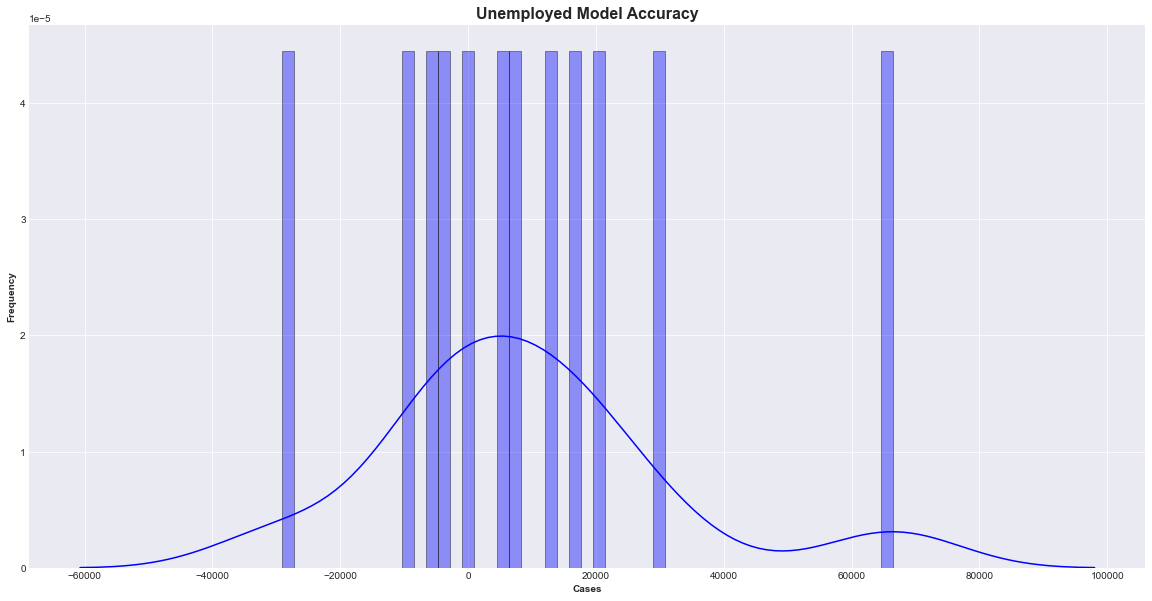

In [49]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Unemployed Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Median Household Income

In [50]:
features_list = ['Median_Household_Income_2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

<ipython-input-50-ff19afbeae79>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForestModel.fit(X_train_scaled, y_train_scaled)


Train MAE Value: 33797.8821965812
Train MSE Value: 2247584082.914155
Train RMS Value: 47408.69206078306
Train R2 Score: 0.7424380323631536


Test MAE Value: 51921.33644444444
Test MSE Value: 5289966904.745892
Test RMS Value: 72732.15866964139
Test R2 Score: 0.10650092220617335


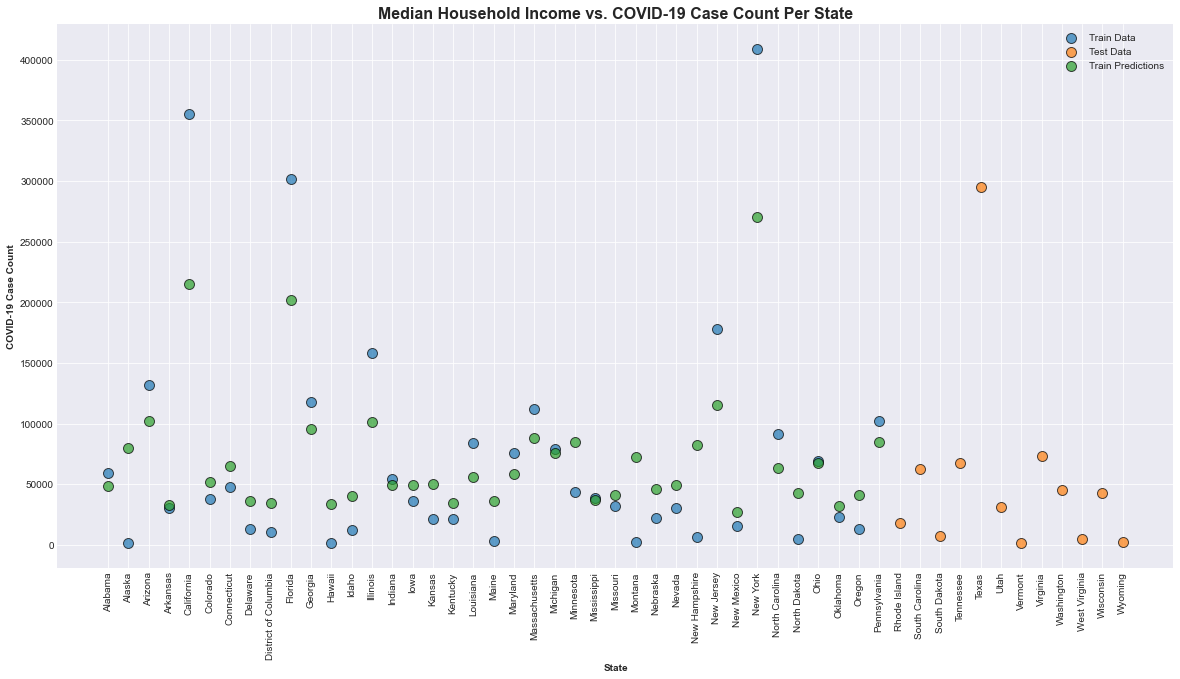

In [51]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Median Household Income vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

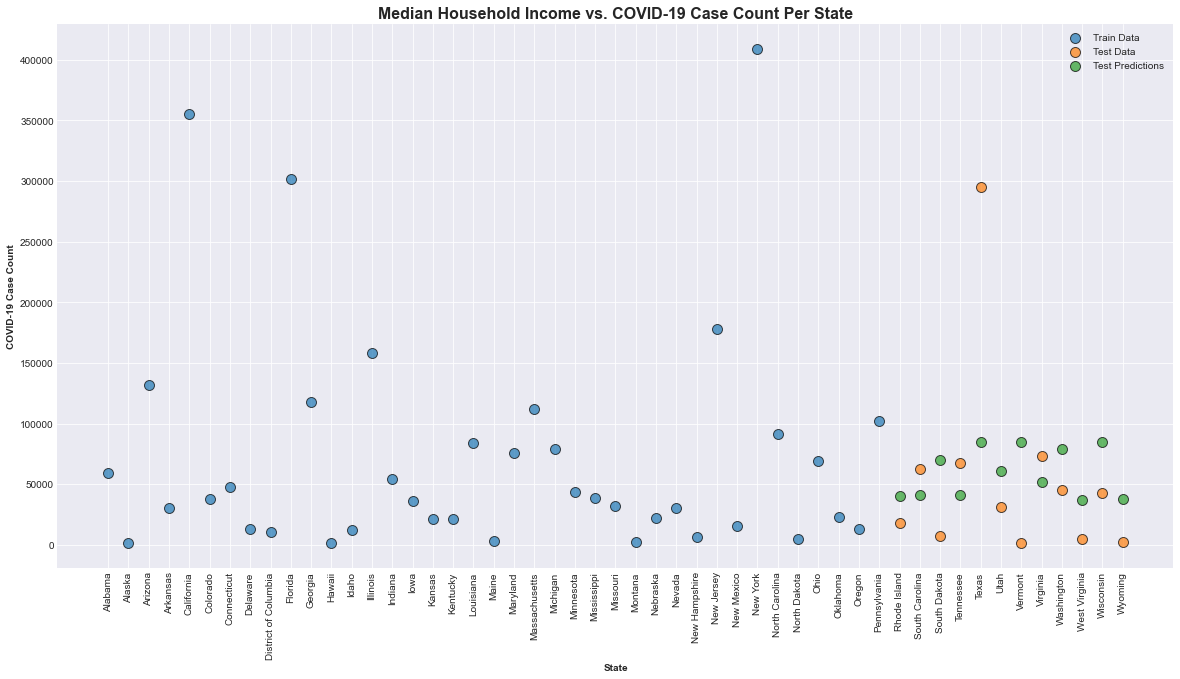

In [52]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Median Household Income vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [53]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7577 degrees.
Accuracy = 95.78%.


95.77892186692645

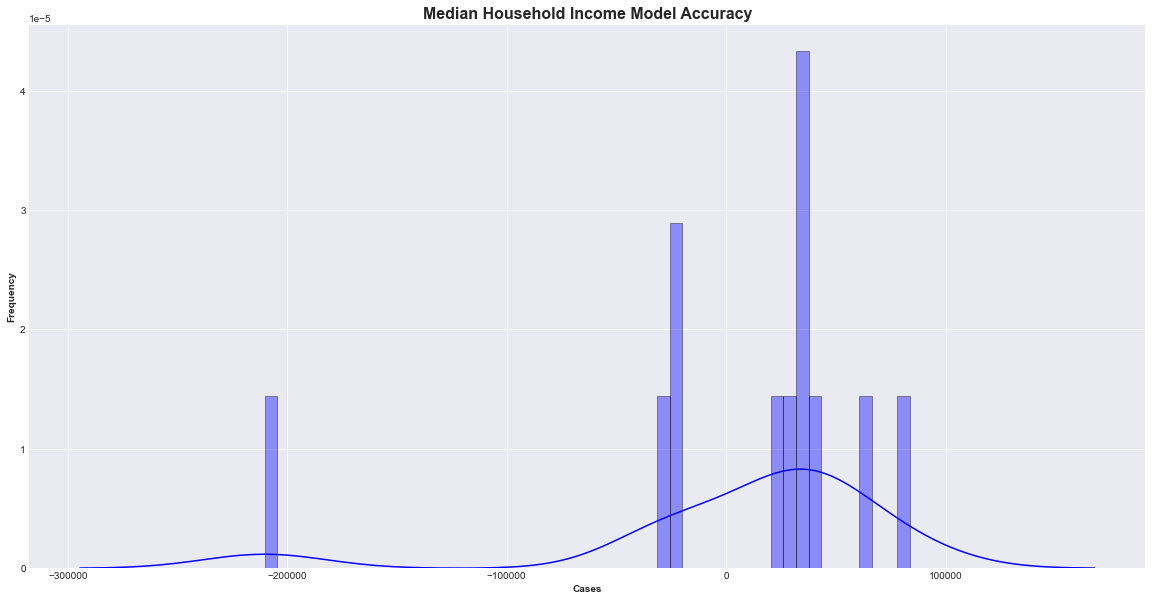

In [54]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Median Household Income Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [55]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [8, 10, 12, 16, 20, 24],
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}

kfold = KFold(n_splits = 4)

RF_NewModel = GridSearchCV(estimator = RandomForestModel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

RF_NewModel.fit(X_train_scaled, y_train_scaled);

Fitting 4 folds for each of 1080 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 24.7min finished
c:\python38\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [56]:
RF_NewModel.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100}

In [57]:
train_predictions_scaled = RF_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RF_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 63466.962798569795
Train MSE Value: 8381445543.179812
Train RMS Value: 91550.23507987193
Train R2 Score: 0.0395279882283629


Test MAE Value: 60186.03791913848
Test MSE Value: 6367266857.819083
Test RMS Value: 79795.15560370243
Test R2 Score: -0.0754598597629279


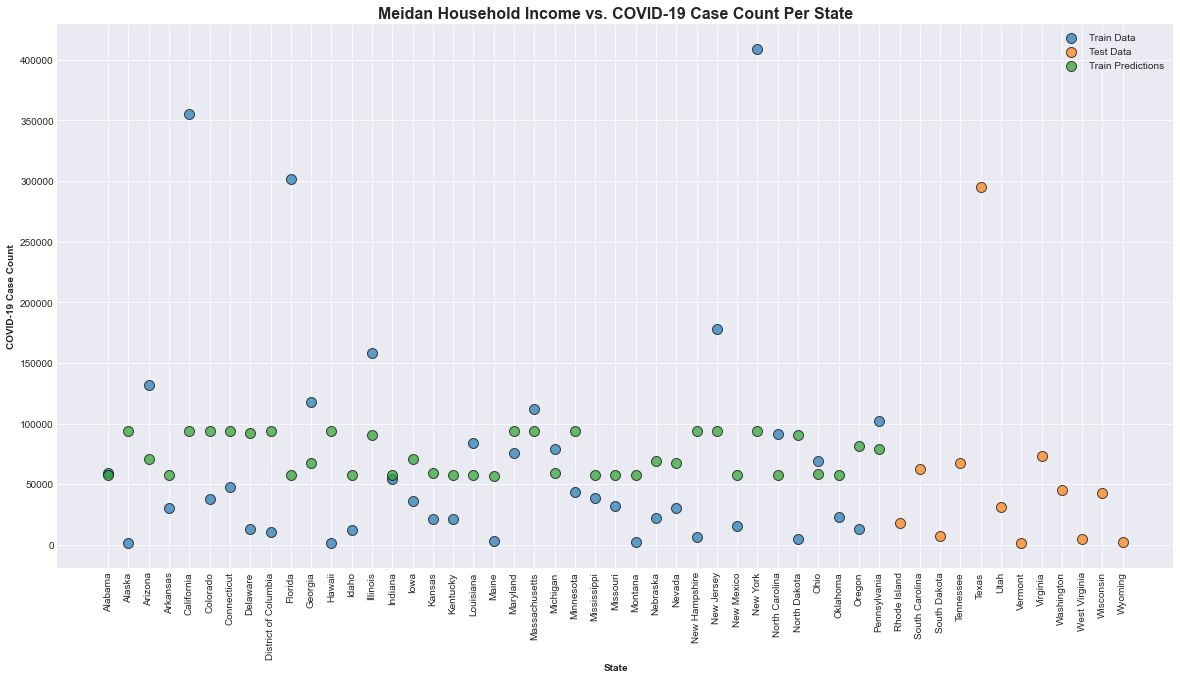

In [58]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Meidan Household Income vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

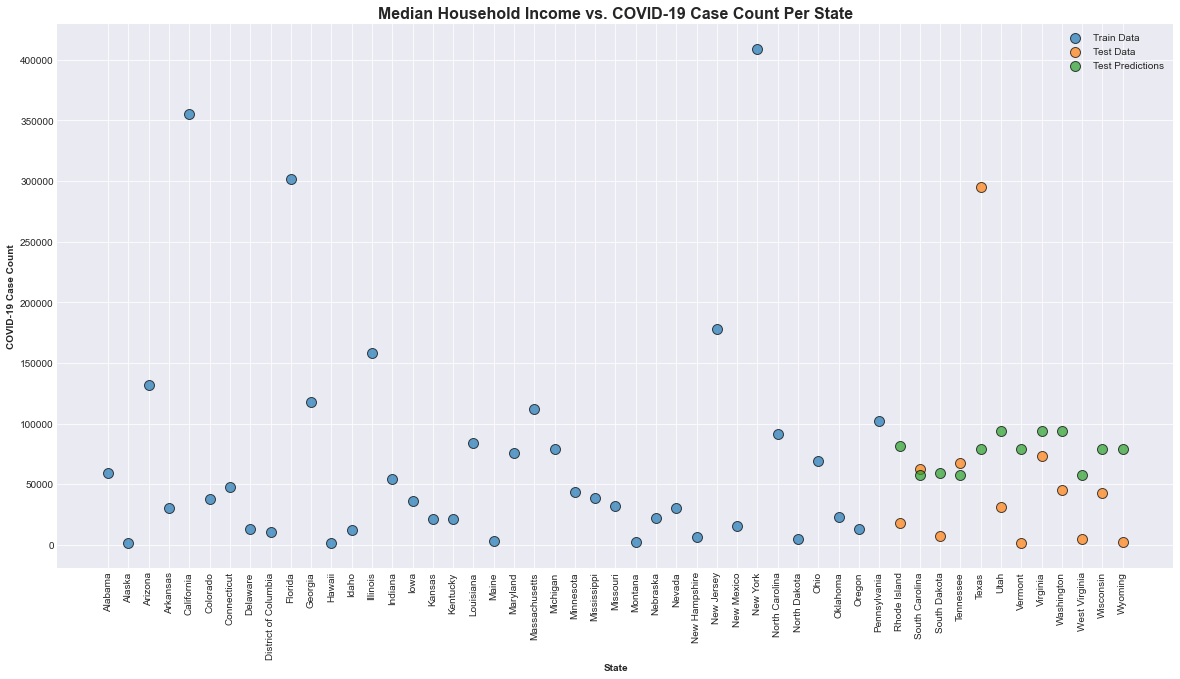

In [59]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Median Household Income vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [60]:
base_accuracy = evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7577 degrees.
Accuracy = 95.78%.


In [61]:
new_accuracy = evaluate(RF_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7000 degrees.
Accuracy = 123.40%.


In [62]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 22.38%.


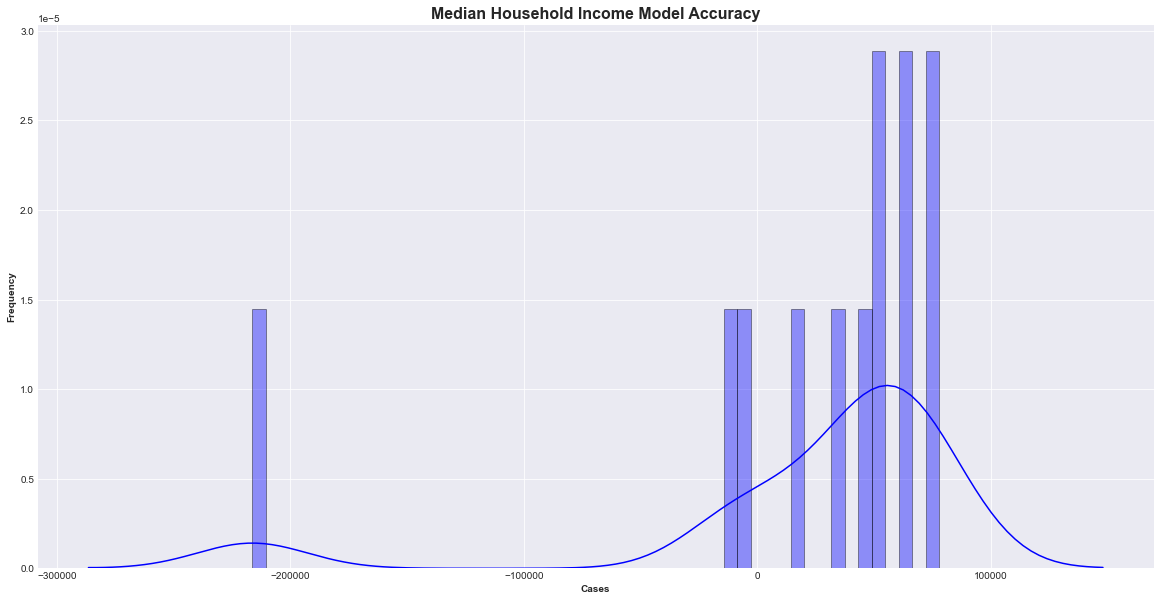

In [63]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Median Household Income Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Overall Employment

In [64]:
features_list = ['Civilian_labor_force_2018','Employed_2018','Unemployed_2018','Median_Household_Income_2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

RandomForestModel = RandomForestRegressor()
RandomForestModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RandomForestModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RandomForestModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

<ipython-input-64-ee106b27cd62>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForestModel.fit(X_train_scaled, y_train_scaled)


Train MAE Value: 7109.652307692315
Train MSE Value: 132884535.9829774
Train RMS Value: 11527.555507694482
Train R2 Score: 0.9847720924807812


Test MAE Value: 19647.458166666664
Test MSE Value: 980094456.0086565
Test RMS Value: 31306.46029190551
Test R2 Score: 0.8344576613874596


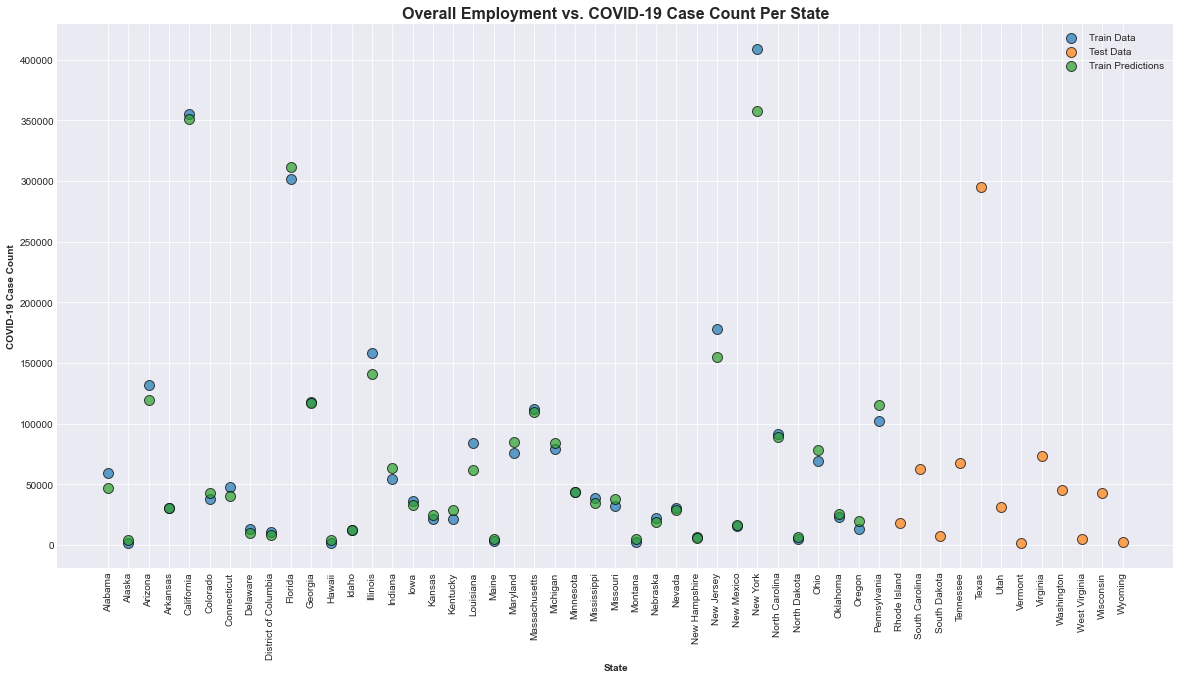

In [65]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Employment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

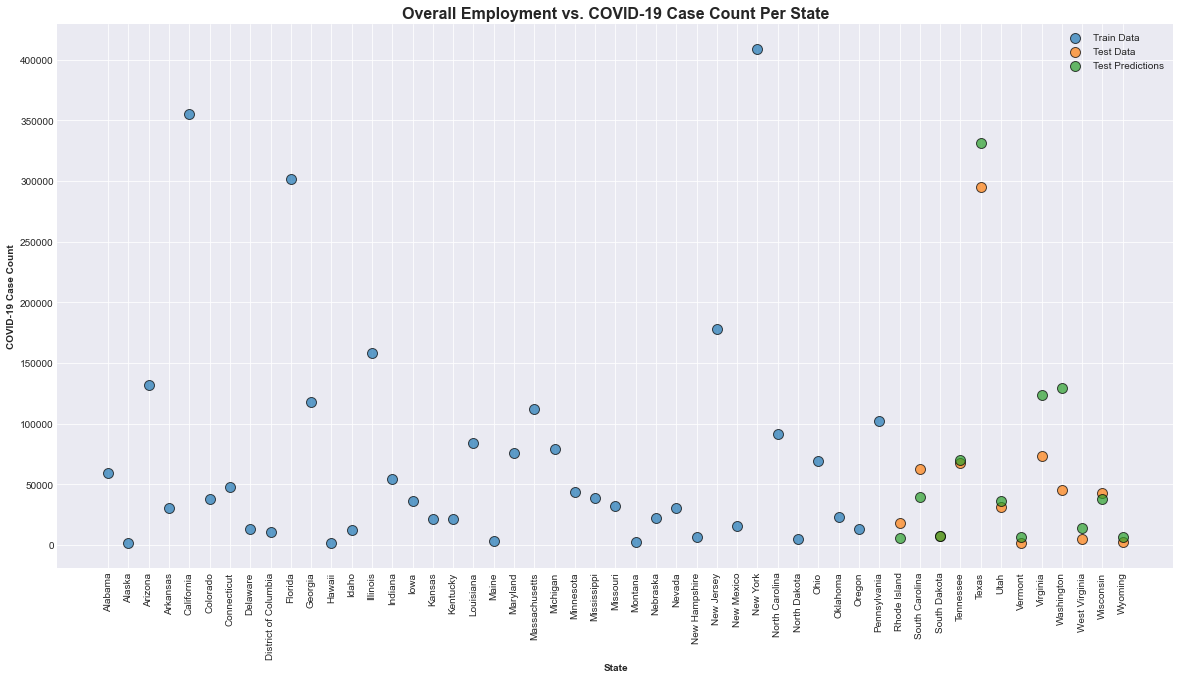

In [66]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Employment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [67]:
evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8911 degrees.
Accuracy = 78.86%.


78.85594620760723

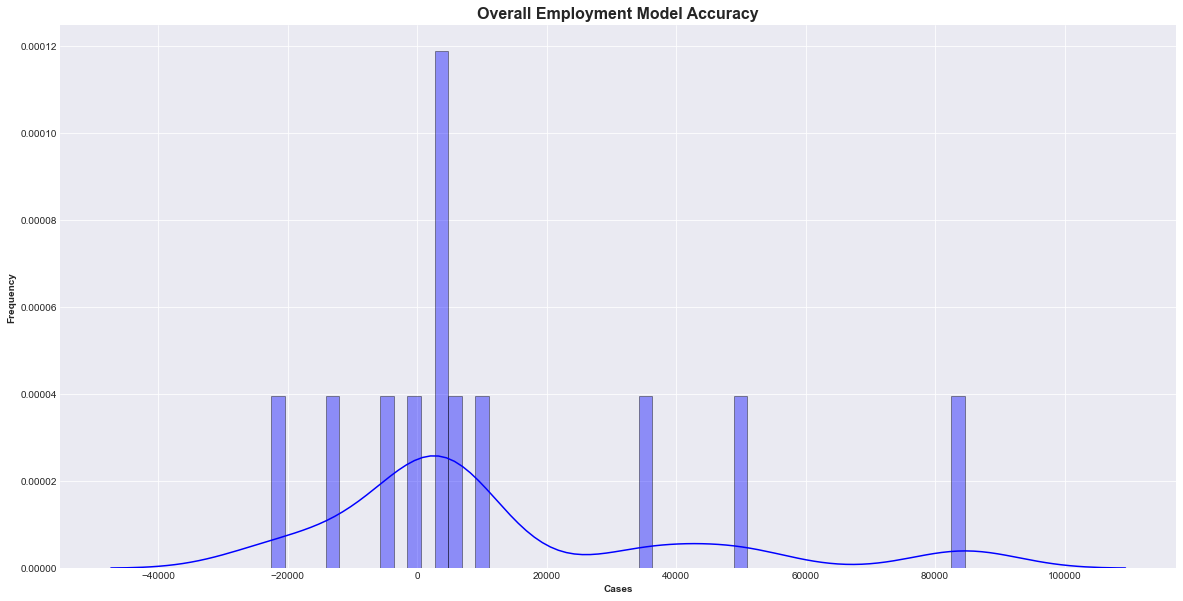

In [68]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Employment Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [69]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [8, 10, 12, 16, 20, 24],
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}

kfold = KFold(n_splits = 4)

RF_NewModel = GridSearchCV(estimator = RandomForestModel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

RF_NewModel.fit(X_train_scaled, y_train_scaled);

Fitting 4 folds for each of 1080 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 21.9min finished
c:\python38\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [70]:
RF_NewModel.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 100}

In [71]:
train_predictions_scaled = RF_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = RF_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 15800.365944506033
Train MSE Value: 592423088.585028
Train RMS Value: 24339.742985188404
Train R2 Score: 0.932111257803704


Test MAE Value: 16959.224475566298
Test MSE Value: 605497359.3161186
Test RMS Value: 24606.855941304624
Test R2 Score: 0.8977287869853815


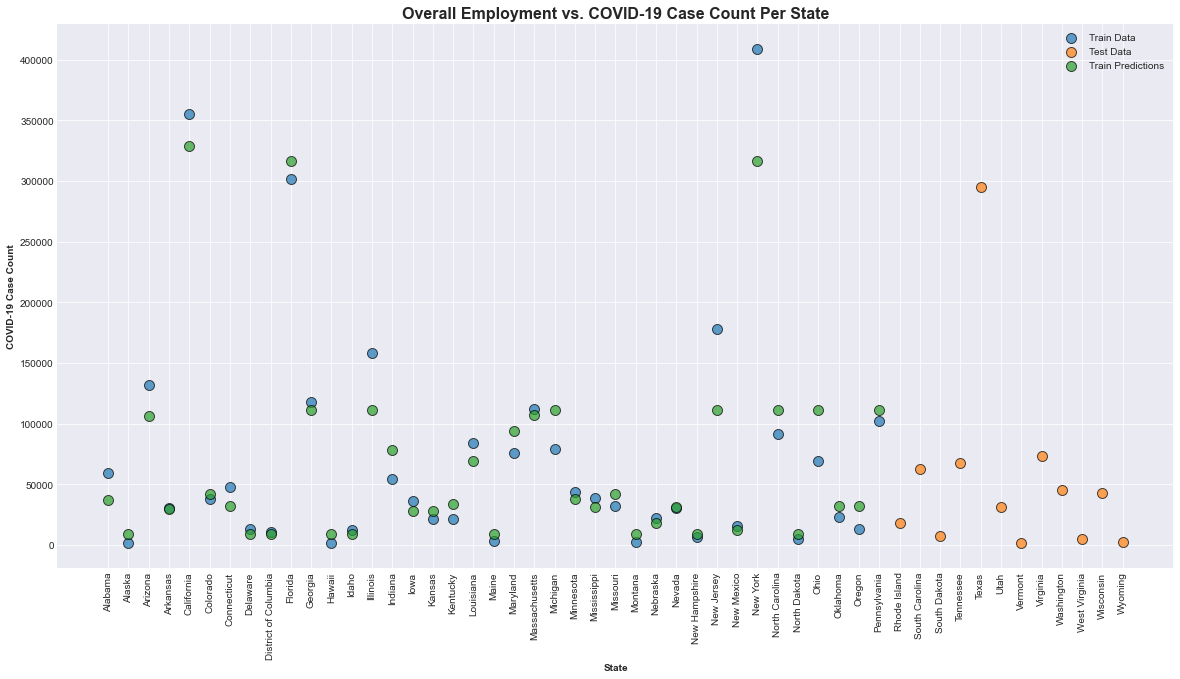

In [72]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Employment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

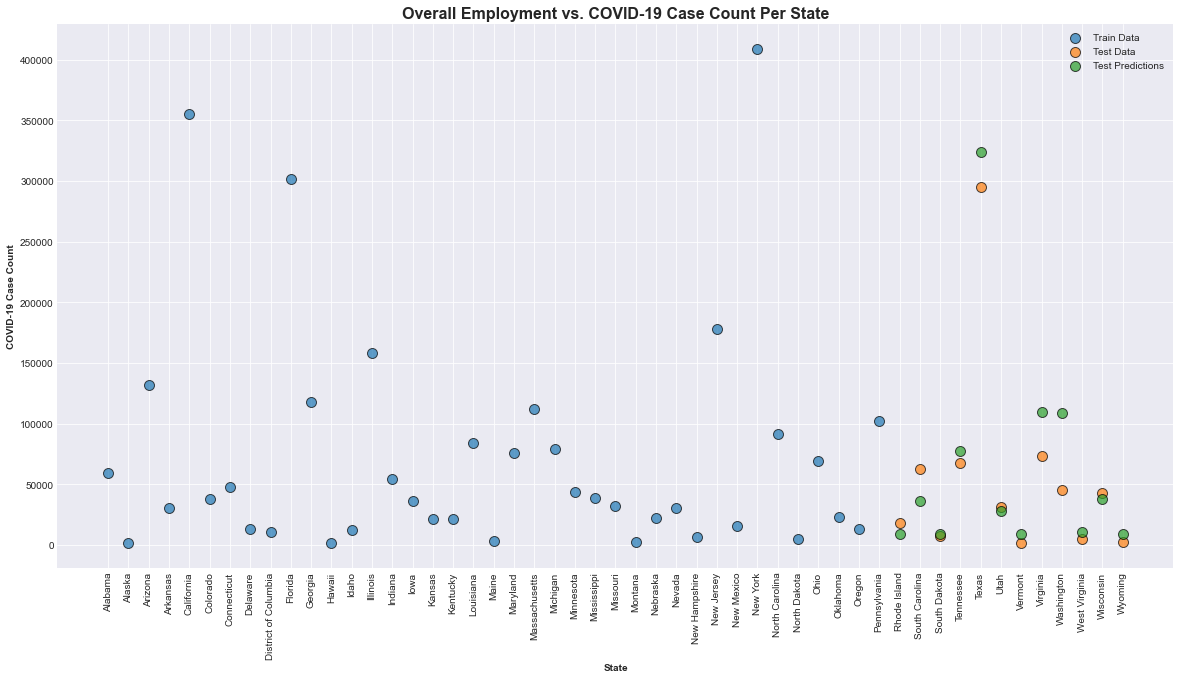

In [73]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Employment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [74]:
base_accuracy = evaluate(RandomForestModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8911 degrees.
Accuracy = 78.86%.


In [75]:
new_accuracy = evaluate(RF_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8697 degrees.
Accuracy = 81.37%.


In [76]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 3.09%.


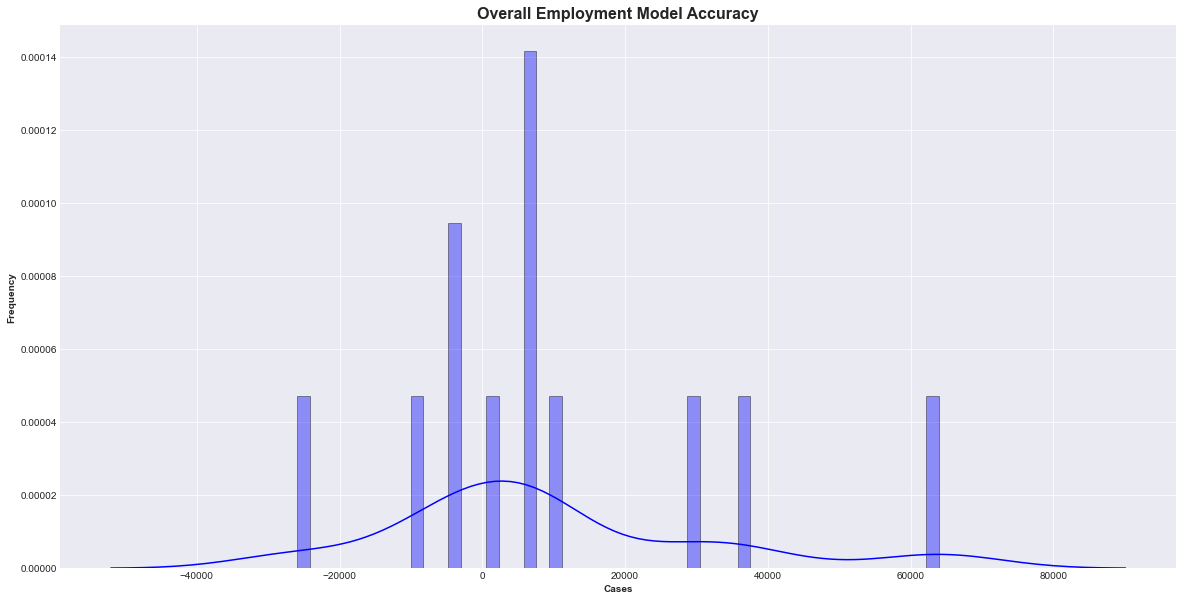

In [77]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Employment Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();